In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score, mean_squared_error,mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg,AR
import json
import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pymc3 as pm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import random
import theano.tensor as tt
import theano
from statsmodels.tsa.arima.model import ARIMA



In [2]:
df=pd.read_csv('/kaggle/input/new-data-climate-pop1/new_data_climate_pop.csv')[['state','elderly_mode','school_mode','mask','ILIp','pca_1','date','resid_av7','unweighted_ili']]
df['date']=pd.to_datetime(df['date'])
df1=(df.set_index('date',drop=True)).sort_values('state')
states=df1['state'].unique()
df1.sort_values(['state','date'],inplace=True)
lag_value=1
df1['school_mode'] = df1['school_mode'].round().astype('float')
df1['elderly_mode'] = df1['elderly_mode'].round().astype('float')
mapping = {0: 'no_policy', 1: 'low_policy', 2: 'med_policy', 3: 'high_policy'}
df1['elderly_mode'] = df1['elderly_mode'].astype(int).map(mapping)
df1['school_mode'] = df1['school_mode'].astype(int).map(mapping)

scaler=StandardScaler()
df1.dropna(inplace=True)
df1_ca=df1[df1['state']=='CA']['2020-03-10':'2022-06-01']
mask = (df1_ca.index >= '2022-01-01') & (df1_ca.index <= '2022-03-01')
#df1_ca=df1_ca[~mask]
df1_ca['diff_ilip']=df1_ca['ILIp'].diff()
df2_ca=df1_ca.dropna()
df2_ca['smoothed_ILIp']=df2_ca['diff_ilip'].rolling(window=7).mean()
df2_ca['school_mode_lag']=df2_ca['school_mode'].shift(4)
df2_ca['elderly_mode_lag']=df2_ca['elderly_mode'].shift(4)
df2_ca[['mask','pca_1','smoothed_ILIp','resid_av7','unweighted_ili']] = scaler.fit_transform(df2_ca[['mask','pca_1','smoothed_ILIp','resid_av7','unweighted_ili']])
df2_ca['smoothed_ILIp_lag']=df2_ca['smoothed_ILIp'].shift(1)
df2_ca['unweighted_ili_lag']=df2_ca['unweighted_ili'].shift(1)
df2_ca.sort_values(['state','date'],inplace=True,ascending=True)
df2_ca['school_temp']=df2_ca['school_mode_lag']
df2_ca = pd.get_dummies(df2_ca, columns=['school_mode_lag'], prefix='school_mode')
df2_ca = pd.get_dummies(df2_ca, columns=['elderly_mode_lag'], prefix='elderly_mode')
df3_ca=df2_ca.dropna()
df3_ca.head()

,state,elderly_mode,school_mode,mask,ILIp,pca_1,resid_av7,unweighted_ili,diff_ilip,smoothed_ILIp,smoothed_ILIp_lag,unweighted_ili_lag,school_temp,school_mode_high_policy,school_mode_low_policy,school_mode_med_policy,elderly_mode_high_policy,elderly_mode_med_policy
date,,,,,,,,,,,,,,,,,,
2020-05-10,CA,high_policy,high_policy,0.229062,0.000028,-1.385501,1.658902,-0.573643,0.000028,-0.697452,-2.926904,-0.608285,high_policy,True,False,False,True,False
2020-05-17,CA,high_policy,high_policy,0.100214,0.000000,-1.436225,1.591167,-0.686826,-0.000028,-0.618014,-0.697452,-0.573643,high_policy,True,False,False,True,False
2020-05-24,CA,high_policy,high_policy,0.024162,0.000000,-1.125512,1.387963,-0.724771,0.000000,-0.388092,-0.618014,-0.686826,high_policy,True,False,False,True,False
2020-05-31,CA,high_policy,high_policy,0.207063,0.000000,-0.892878,1.218626,-1.027054,0.000000,-0.250841,-0.388092,-0.724771,high_policy,True,False,False,True,False
2020-06-07,CA,high_policy,high_policy,0.286257,0.000000,-0.352957,0.846085,-0.984029,0.000000,-0.286285,-0.250841,-1.027054,high_policy,True,False,False,True,False


In [6]:
df3_ca['mask_lag']=df3_ca['mask'].shift(4)
df3_ca['resid_av7_lag']=df3_ca['resid_av7'].shift(4)
df3_ca['pca_1_lag']=df3_ca['pca_1'].shift(4)

df3_ca.dropna(inplace=True)

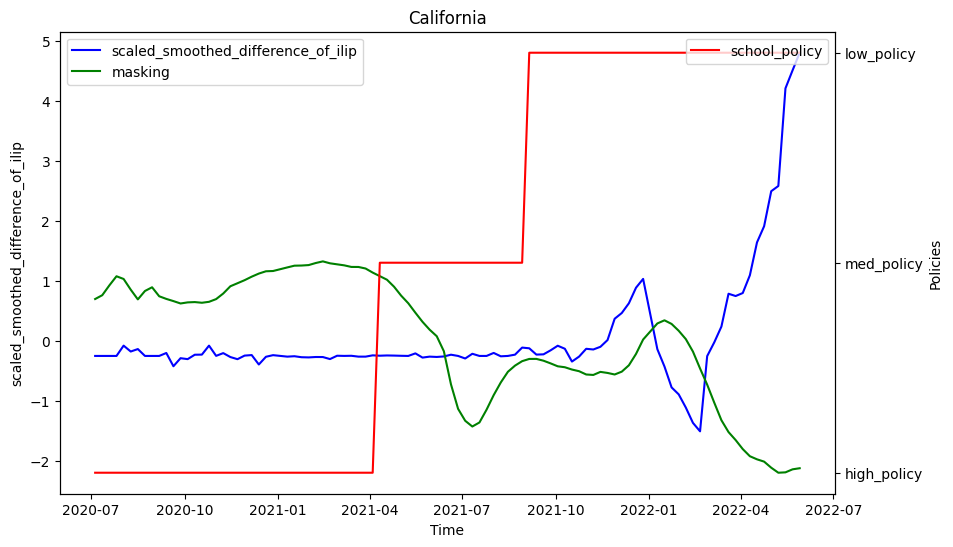

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_title('California')
ax1.plot(df3_ca['smoothed_ILIp'], label='scaled_smoothed_difference_of_ilip', color='blue')
ax1.plot(df3_ca['mask'], label='masking', color='green')
# Set labels and legend for the primary axis
ax1.set_xlabel('Time')
ax1.set_ylabel('scaled_smoothed_difference_of_ilip')
ax1.legend(loc='upper left')

# Create a twin axis for 'school_temp'
ax2 = ax1.twinx()

# Plot the 'school_temp' data on the twin axis
ax2.plot(df3_ca['school_temp'], label='school_policy', color='red')

# Set labels and legend for the twin axis
ax2.set_ylabel('Policies')
ax2.legend(loc='upper right')

plt.show()

In [27]:
"""import numpy as np
import pandas as pd
import pymc3 as pm

# Step 1: Generate synthetic data
np.random.seed(42)

# Create a synthetic dataset
n_samples = 1000
categorical_variable = np.random.choice(['A', 'B', 'C'], n_samples)
true_coefficients = {'A': 2.0, 'B': 3.0, 'C': 1.5}
Y = np.array([true_coefficients[category] for category in categorical_variable]) + np.random.normal(0, 1, n_samples)

data = pd.DataFrame({'Y': Y, 'Category': categorical_variable})

# Convert categorical variable to one-hot encoding
data = pd.get_dummies(data, columns=['Category'], prefix='Category')
with pm.Model() as model:
    # Priors for coefficients for 'A', 'B', and 'C'
    beta_A = pm.Normal('beta_A', mu=0, sd=1)
    beta_B = pm.Normal('beta_B', mu=0, sd=1)
    beta_C = pm.Normal('beta_C', mu=0, sd=1)
    
    # Intercept (using a non-informative prior)
    #intercept = pm.Normal('intercept', mu=0, sd=1)
    
    # Calculate the expected value mu based on the categorical variable
    mu =  beta_A * data['Category_A'] +beta_B * data['Category_B'] + beta_C * data['Category_C']
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sd=1)
    likelihood = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=data['Y'])

# Step 3: Perform Bayesian inference
with model:
    trace = pm.sample(2000, tune=1000, cores=1)"""

"import numpy as np\nimport pandas as pd\nimport pymc3 as pm\n\n# Step 1: Generate synthetic data\nnp.random.seed(42)\n\n# Create a synthetic dataset\nn_samples = 1000\ncategorical_variable = np.random.choice(['A', 'B', 'C'], n_samples)\ntrue_coefficients = {'A': 2.0, 'B': 3.0, 'C': 1.5}\nY = np.array([true_coefficients[category] for category in categorical_variable]) + np.random.normal(0, 1, n_samples)\n\ndata = pd.DataFrame({'Y': Y, 'Category': categorical_variable})\n\n# Convert categorical variable to one-hot encoding\ndata = pd.get_dummies(data, columns=['Category'], prefix='Category')\nwith pm.Model() as model:\n    # Priors for coefficients for 'A', 'B', and 'C'\n    beta_A = pm.Normal('beta_A', mu=0, sd=1)\n    beta_B = pm.Normal('beta_B', mu=0, sd=1)\n    beta_C = pm.Normal('beta_C', mu=0, sd=1)\n    \n    # Intercept (using a non-informative prior)\n    #intercept = pm.Normal('intercept', mu=0, sd=1)\n    \n    # Calculate the expected value mu based on the categorical variab

In [8]:
with pm.Model() as hierarchical_model:
    random.seed(2)
    np.random.seed(2)
            #PRIORS
    b_pca_1= pm.Normal('pca_1', mu=0., sd=1)
    b_masking= pm.Normal('b_masking', mu=-3., sd=1)
    b_school_low= pm.Normal('b_school_low', mu=-2., sd=1)
    b_school_med= pm.Normal('b_school_med', mu=-1, sd=1)
    b_school_high= pm.Normal('b_school_high', mu=-1., sd=1)
    b_elderly_med= pm.Normal('b_elderly_med', mu=0., sd=1)
    b_elderly_high= pm.Normal('b_elderly_high', mu=0., sd=1)

    b_ili_lag_1 = pm.Normal(f'ili_lag_1', mu=0, sd=1)
    a = pm.Normal(f'alpha', mu=0, sd=1)
    formula= (a + b_ili_lag_1*df3_ca['smoothed_ILIp_lag'] + b_masking*df3_ca['mask_lag']
                + b_pca_1*df3_ca['pca_1'])
    
    formula+=(b_school_low * df3_ca['school_mode_low_policy'] +b_school_med * df3_ca['school_mode_med_policy']
                            + b_school_high * df3_ca['school_mode_high_policy'])
    formula+=(b_elderly_med * df3_ca['elderly_mode_med_policy']+ b_elderly_high * df3_ca['elderly_mode_high_policy'])
    sigma = pm.HalfNormal('sigma', sd=1)   
    pm.Normal(f'y_like', mu=formula,sigma=sigma,observed=df3_ca['smoothed_ILIp'])
    trace=pm.sample(draws=1000, tune=1000,cores=1)
    predictions = pm.sample_posterior_predictive(trace, samples=1000, model=hierarchical_model)


In [9]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pca_1,0.056,0.056,-0.045,0.163,0.001,0.001,1826.0,1414.0,1.01
b_masking,-0.180,0.090,-0.347,-0.007,0.003,0.002,1209.0,1237.0,1.00
b_school_low,-1.017,0.521,-2.007,-0.067,0.017,0.013,886.0,911.0,1.00
b_school_med,-1.189,0.517,-2.110,-0.192,0.018,0.013,855.0,879.0,1.00
b_school_high,-1.102,0.518,-2.077,-0.136,0.018,0.013,854.0,966.0,1.00
b_elderly_med,0.242,0.585,-0.789,1.427,0.018,0.015,1004.0,1047.0,1.00
b_elderly_high,0.549,0.585,-0.657,1.568,0.018,0.014,1032.0,1201.0,1.00
ili_lag_1,1.000,0.054,0.905,1.110,0.002,0.001,1251.0,1326.0,1.00
alpha,0.747,0.664,-0.448,2.043,0.020,0.015,1068.0,1009.0,1.00
sigma,0.271,0.021,0.232,0.309,0.001,0.000,1487.0,1500.0,1.00


0.932780149612427


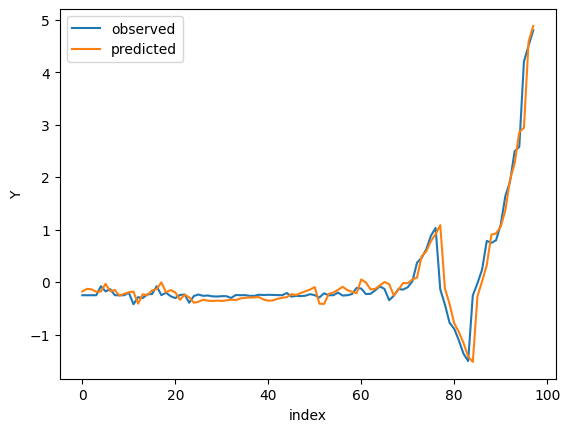

In [10]:
pred=predictions['y_like']
mean_pred=pred.mean(axis=0)
observed=df3_ca['smoothed_ILIp'].values
r2 = r2_score(observed, mean_pred)
print(r2)
plt.plot(observed,label='observed')
plt.plot(mean_pred,label='predicted')
plt.ylabel('Y')
plt.xlabel('index')

plt.legend()

array([[<Axes: title={'center': 'resid_av7'}>,
        <Axes: title={'center': 'resid_av7'}>],
       [<Axes: title={'center': 'b_masking'}>,
        <Axes: title={'center': 'b_masking'}>],
       [<Axes: title={'center': 'b_school_low'}>,
        <Axes: title={'center': 'b_school_low'}>],
       [<Axes: title={'center': 'b_school_med'}>,
        <Axes: title={'center': 'b_school_med'}>],
       [<Axes: title={'center': 'b_school_high'}>,
        <Axes: title={'center': 'b_school_high'}>],
       [<Axes: title={'center': 'b_elderly_med'}>,
        <Axes: title={'center': 'b_elderly_med'}>],
       [<Axes: title={'center': 'b_elderly_high'}>,
        <Axes: title={'center': 'b_elderly_high'}>],
       [<Axes: title={'center': 'ili_lag_1'}>,
        <Axes: title={'center': 'ili_lag_1'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

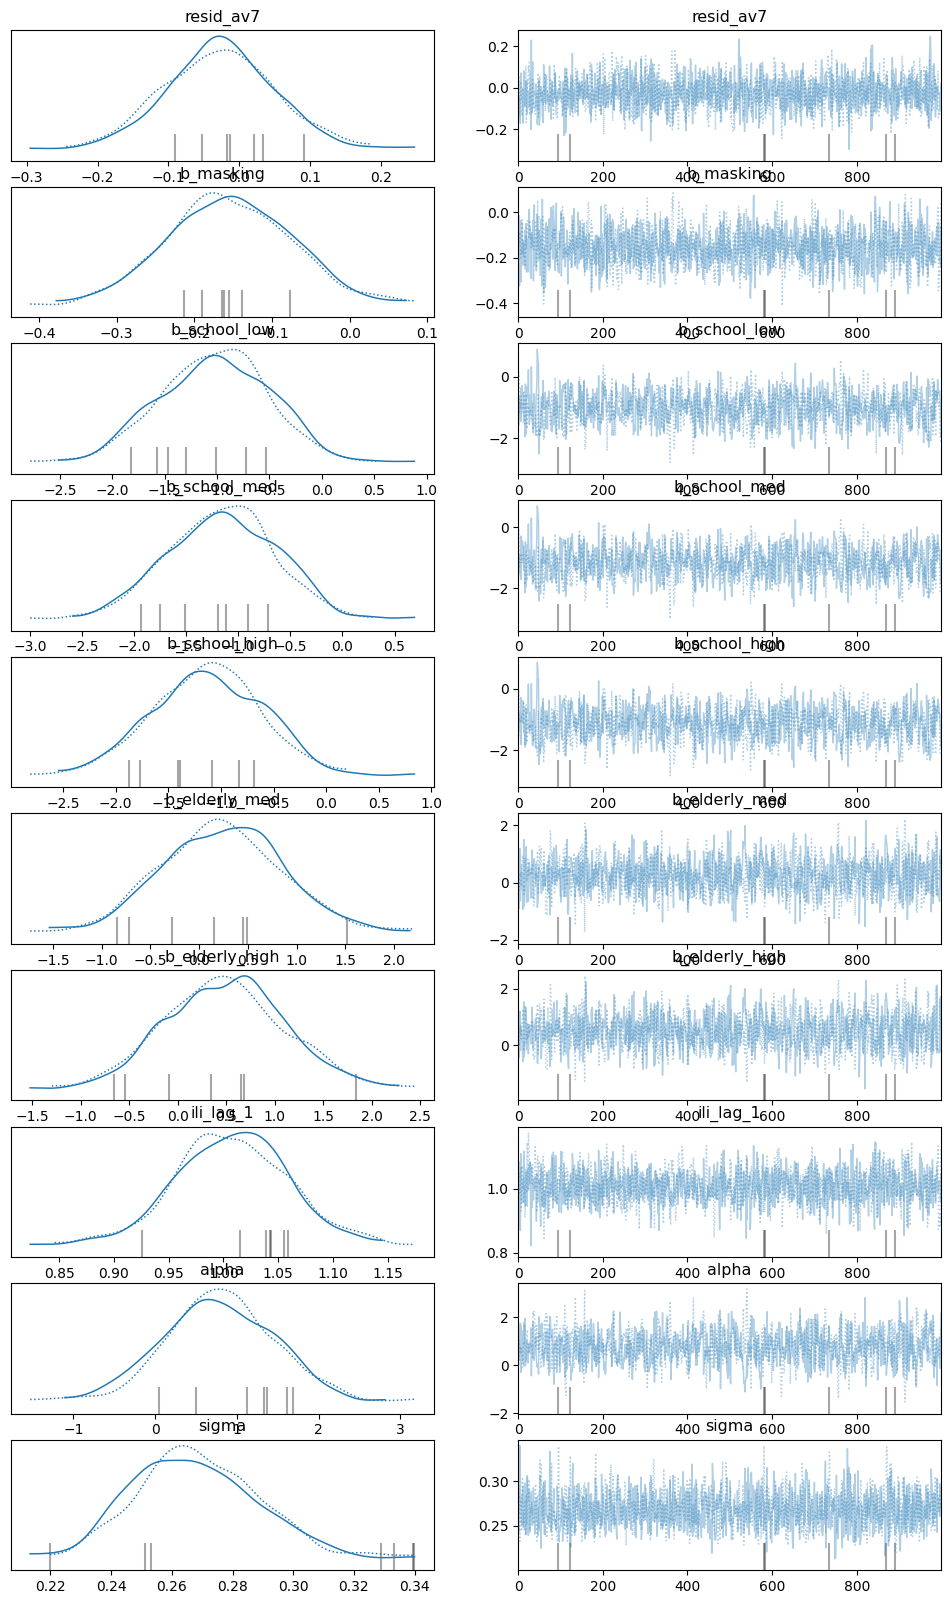

In [32]:
az.plot_trace(trace)
